In [1]:
import sys
import os
import itertools

import numpy as np
import torch as tr
from CSWSEM import *

In [2]:
import os
import numpy as np
import torch as tr
import pandas as pd

from CSWSEM import *
from matplotlib import pyplot as plt

%load_ext autoreload
%reload_ext autoreload
%autoreload 2

In [3]:
## input params
learn_rate = 0.01
alfa = 0.01
lmda = 100000
stsize = 25

In [6]:
condL = ['blocked','interleaved']

exp_kwargs={
    'n_train':160,
    'n_test':40
}

sem_kwargs={
    'nosplit':False,
    'stsize':stsize,
    'lmda':lmda,
    'alfa':alfa,
    'learn_rate':learn_rate,
}


dataL = []
for seed in np.arange(3):
  for cond in condL:
    print(seed,cond)
    np.random.seed(seed)
    tr.manual_seed(seed)
    sem_kwargs['seed']=seed
    # setup
    exp_kwargs['condition'] = cond
    task = CSWTask()
    sem = SEM(**sem_kwargs)
    exp,curr = task.generate_experiment(**exp_kwargs)
    # run
    sem_data = sem.forward_exp(exp,curr)
    sem.data.record_exp('condition',exp_kwargs['condition'])
    dataL.append(pd.DataFrame(sem_data))
    exphat = np.array([tdata['event_hat'] for tdata in sem_data])
data = pd.concat(dataL)

0 blocked
0 interleaved
1 blocked
1 interleaved
2 blocked
2 interleaved


In [8]:
""" 
concat sem_data from multiple 
seeds and conditions
"""
# def format_dataL(dataL):
df = pd.concat(dataL)
df = df.astype({'loss':float})
df.loc[:,'acc1'] = 1-df.loss
#   return df
# format_dataL(dataL)

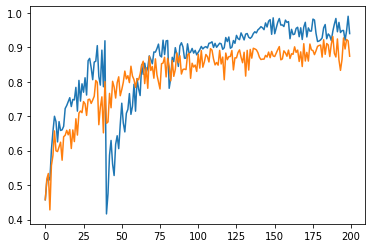

In [9]:
df.groupby(['condition','seed','trial']).mean()
for cond in ['blocked','interleaved']:
  cond_df = df[df.loc[:,'condition'] == cond]
  M = cond_df.groupby('trial').mean()
  plt.plot(M.loc[:,'acc1'])

In [24]:
""" move into task
"""
from sklearn.linear_model import LogisticRegression
clf_class = LogisticRegression
clf_kwargs = dict(C=10.0, multi_class='multinomial', solver='lbfgs')
# clf_kwargs = dict(C=1.0, multi_class='multinomial', solver='lbfgs')
decoder = clf_class(**clf_kwargs)
decoder.fit(task.embed_mat,
            np.arange(task.embed_mat.shape[0])
           )


LogisticRegression(C=10.0, multi_class='multinomial')

In [25]:
exphat_proba = decoder.predict_proba(
              exphat.reshape(-1,10)
              ).reshape(200,5,11)

In [121]:


def get_response(exphat_proba):
  """ 
  takes output of SEM/LSTM `exphat_proba`
  which contains probability distribution 
  over the scenes 
    i.e. assumes exphat_proba is the output
    of a sklearn.classifier.predict_proba method
  collapses this probability distribution into
  an integer corresponding to one of the scenes
  
  returns exp_hat_idx for two relevant layers
    shape: [(layer1,layer2)),200]
    where [0,:] contains (5,6)
  
  """
  layerL = [3,4]
  scenesL = [[5,6],[7,8]]
  exp_hat_idx = -np.ones([2,200],dtype=int)
  for idx,(layer_idx,scenes) in enumerate(zip(layerL,scenesL)):
    # get relevant probas
    layer_proba = exphat_proba[:,layer_idx,scenes]
    # normalize
    layer_proba /= layer_proba.sum(1,keepdims=1)
    # select scene_idx corresponding to argmax
    # np.take helps broadcast index of argmax [0,1]
    # over dimensions of repeated scenes corresponding to layer
    exp_hat_idx[idx] = np.take(
      np.repeat([scenes],200,axis=0),
      layer_proba.argmax(1)
    )
  return exp_hat_idx
  
## translate_2afc
def calc_acc(exp,exphat_proba):
  """ 
  exp & exphat [trials, timesteps, obsdim]
  exp has 6 timestps
  exphat has 5 timesteps (no prediction for begin)
  exphat_proba is exphat passed through a classifier
  """
  return acc

array([5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 6, 5, 6, 6, 6, 5, 6, 5, 6, 5, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 5, 6, 6, 6, 6, 6, 5, 6, 5, 6, 5, 6, 5, 6, 5,
       6, 6, 6, 6, 6, 6, 6, 6, 5, 6, 5, 6, 5, 5, 6, 5, 6, 6, 5, 6, 5, 6,
       5, 6, 5, 6, 5, 6, 5, 6, 6, 5, 5, 6, 5, 5, 5, 6, 6, 6, 6, 5, 5, 6,
       5, 5, 6, 6, 6, 6, 5, 5, 6, 6, 6, 5, 5, 5, 5, 5, 6, 6, 6, 5, 5, 6,
       5, 6, 6, 5, 5, 6, 6, 5, 5, 6, 6, 6, 5, 5, 6, 6, 5, 6, 6, 6, 5, 5,
       5, 5, 5, 5, 5, 6, 5, 6, 6, 6, 6, 5, 6, 5, 6, 6, 5, 6, 5, 6, 5, 6,
       6, 6, 5, 6, 6, 6, 5, 6, 5, 6, 5, 5, 6, 6, 5, 5, 5, 6, 6, 6, 5, 5,
       6, 5, 5, 5, 5, 6, 6, 5, 5, 5, 5, 6, 5, 5, 6, 6, 5, 6, 6, 5, 5, 6,
       5, 5])